## <font color='blue'>SME0104 - Cálculo Numérico</font>

### Primeiro Trabalho em Grupo 
#### Comparação de Métodos na Solução do Laplaciano em Grafos para propagação de informação

**Luis Gustavo Nonato**

------

Considere os arquivos `manh.el` e `manh.xy` que fornecem as arestas e as coordenadas dos vértices do grafo de ruas da ilha de Manhattan, NY (arquivos disponíveis para download no Google Drive).

O grafo de ruas possui diversas componentes conexas, considerando somente a maior componente conexa, você deve realizar as seguintes tarefas:
1. Selecione alguns vértices do grafo $v_{i_1},v_{i_2},\ldots,v_{i_k},\, k<<n$ ($n$ é o número de vértices na maior componente do grafo e $k$ é um número bem menor que $n$, $k=10$ por exemplo) e atribua valores distindos $c_{i_1},c_{i_2},\ldots,c_{i_k}$ a cada um dos vértices selecionados (por exemplo valores no intervalo (0,10]);

---


2. Construa a matriz Laplaciana $L$ do grafo de ruas;
3. Construa a matriz de penalidades $P$, sendo $P$ é uma matriz diagonal onde a entrada $P_{jj}=\alpha$ se $j$ corresponde ao índice de algum dos vértices escolhidos no item 1 acima ($\alpha=1.0e7$ por exemplo), sendo $P_{ii}=0$ caso contrário.
4. Construa um vetor $b$ da seguinte forma:
$$
b_{j} = \left\{\begin{matrix} c_{i_s} & \:{ se } \: j = i_s \\ 0 & \:{ caso \: contrário}\end{matrix}\right.
$$
5. Compare o tempo de solução do sistema
$$
(L+P)x = b
$$
para os métodos:
    - Decomposição LU
    - Cholesky
    - Jacobi e Gaus-Seidel
    - Gradientes Conjugados
    
6. Refaça as tarefas com representação por matriz esparsa e matrizes cheias, comparando os resultados.

Alunos: 
- Kauê Hunnicutt Bazilli - 11212226
- Matheus Vieira Gonçalves - 11200397
- Pedro Henrique dias Junqueira de Souza - 11294312

In [1]:
import sys
import time

# Bagulho chato
#%pip install --prefix {sys.prefix} numpy
#%pip install --prefix {sys.prefix} scipy
#%pip install --prefix {sys.prefix} networkx
#%pip install --prefix {sys.prefix} matplotlib

import numpy as np
import scipy as sci
from scipy.sparse import linalg
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Construção do grafo em memória com base nos arquivos
G = nx.Graph()

#Nós
with open("./manh.xy","r") as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        [x, y] = map(float, line.split("\t")) #Lê como floats
        G.add_node(i, data=(x, y))

#Arestas
with open("./manh.el","r") as file:
    lines = file.readlines()
    for line in lines:
        [x, y] = map(int, line.split("\t")) #Lê como ints
        G.add_edge(x,y)
        
use_second = False
if use_second:
    Graphs = nx.connected_components(G)
    cont = 0
    for i in Graphs:
        cont += 1
        if (cont == 2):
            G = G.subgraph(i).copy()
            break
else:
    LCC_generator = max(nx.connected_components(G), key=len)
    G = G.subgraph(LCC_generator).copy()

# Desse ponto em diante, G é a maior componente conexa

In [3]:
# 1) Selecione alguns vértices do grafo e atribua valores distintos a cada um dos vértices selecionados

# Uma lista dos índices e outra lista com os seus respectivos valores
c_indexes = np.random.randint(0, len(G), 10)
c_values = np.random.uniform(0, 10, len(c_indexes))

In [4]:
# 2) Construa a matriz Laplaciana L do grafo de ruas

# Obtendo a matriz laplaciana
L = np.array(nx.laplacian_matrix(G).todense())
L.shape

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(123, 123)

In [5]:
# 3) Construa a matriz de penalidades P

P_diag =  [1e7 if i in c_indexes else 0 for i in range(len(G))]
P = np.diag(P_diag)

In [6]:
# 4) Construa o vetor b 
# Px = b
# b é um vetor com ci nos índices i escolhidos na 1) e 0 em todo o resto.
b = np.zeros(len(G))
for i,ci in enumerate(c_indexes):
    b[ci] = c_values[i]

In [7]:
# TODO: 5) Compare o tempo de solução do sistema (L + P)x = Px = b para os métodos:
#   - Decomposição LU
#   - Cholesky
#   - Jacobi e Gaus-Seidel
#   - Gradientes Conjugados
# NOTE: Pode usar métodos embutidos do numpy e etc...
#
# Lx = 0
# Px = b
#
# Nem P nem L são invertíveis, mas (L + P) é, então resolvemos a soma dos sistemas:
#
# (L + P)x = Px = b

L_plus_P_dense = np.add(L, P)
L_plus_P_csc_sparse =sci.sparse.csc_matrix(L_plus_P_dense)

b_dense = b

print(L_plus_P_csc_sparse.shape)
print(L_plus_P_dense.shape)
print(b_dense.shape)

(123, 123)
(123, 123)
(123,)


In [8]:
# Testes de convergência

# Teste da existência da decomposição LU:

# Para a existência da decomposição LU, é necessário que a matriz tenha
# os determinantes dos menores principais não-nulos.
def first_minor_determinants_not_null(m):
    for i in range(1,len(m)+1):
        first_minor_determinant = sci.linalg.det(m[0:i,0:i])
        if first_minor_determinant == 0:
            return False

    return True

# Essa operação é mais custosa do que a decomposição LU em si, devido
# à grande quantidade de determinantes que devem ser calculados. 
# Após o teste da execução da decomposição LU, é possível concluir que ela de fato
# existe, e, como esta é uma condição necessária, pode-se inferir que o teste
# é bem sucedido.
lu_possible = True #first_minor_determinants_not_null(L_plus_P_dense)
print(f"Decomposição LU é possível: {lu_possible}")


# Teste da existência da decomposição de Cholesky:

# Para verificar se é possível realizar a decomposição de Cholesky,
# é necessário verificar se a matriz é simétrica e positiva definida.
def is_symmetric(m):
    #Compara matriz com sua transposta
    return np.allclose(m, m.T) 

# É possível concluir que uma matriz é positiva definida se ela 
# tem autovalores positivos. É possível usar a matriz esparsa aqui 
# para otimizar os cálculos.
def is_pos_def(m):
    # Calcula autovalores
    eigs = sci.sparse.linalg.eigs(m, return_eigenvectors=False)

    for eigenvalue in eigs:
        if eigenvalue <= 0:
            return False
    
    return True


cholesky_possible = is_symmetric(L_plus_P_dense) and is_pos_def(L_plus_P_csc_sparse)
print(f"Decomposição de Cholesky é possível: {cholesky_possible}")


# Teste da convergência do método de Jacobi

# Como condição suficiente para a convergência do método de Jacobi, 
# pode-se usar o critério das linhas ou o critério das colunas, bastando
# um deles ser atendido. Como essas condições são suficientes, e não 
# necessárias, pode ser que o método venha a convergir mesmo com a 
# falha desses critérios. 

# Critério das linhas
def row_criterion(m):
    for i in range(len(m)):
        line_sum = 0
        for j in range(len(m[i])):
            if(i != j):
                line_sum += (abs(m[i][j])/abs(m[i][i]))
        
        if(line_sum >= 1):
            return False

    return True

# Critério das colunas
def column_criterion(m):
    for i in range(len(m)):
        column_sum = 0
        for j in range(len(m[i])):
            if(i != j):
                column_sum += (abs(m[j][i])/abs(m[i][i]))
        
        if(column_sum >= 1):
            return False

    return True

jacobi_guaranteed = row_criterion(L_plus_P_dense) or column_criterion(L_plus_P_dense)
print(f"Método de Jacobi tem convergência garantida: {jacobi_guaranteed}")

# Teste da convergência do método de Gauss-Seidel

# Mais uma vez, temos apenas condições suficientes, e não
# necessárias para a convergência: Deve ser atendido o critério das linhas
# e o critério de Sassenfeld.

def sassenfeld_criterion(m):
    b = [0]
    for j in range(1,len(m)):
        b[0] += abs(m[0][j])
    b[0] /= abs(m[0][0])

    for i in range(1,len(m)):
        b.append(0)
        for j in range(0,i):
            b[i] += abs(m[i][j])*b[j]
        for j in range(i+1,len(m)):
            b[i] += abs(m[i][j])
        b[i] /= abs(m[i][i])

    if(max(b) < 1):
        return True
    else:
        return False

gauss_seidel_guaranteed = row_criterion(L_plus_P_dense) and sassenfeld_criterion(L_plus_P_dense)
print(f"Método de Gauss-seidel tem convergência garantida: {gauss_seidel_guaranteed}")

# Teste de convergência para o método dos gradientes conjugados:

# Para que o método dos gradientes conjugados convirja, temos a condição
# suficiente de que a matriz seja simétrica e positiva definida

conjugate_gradient_guaranteed = is_pos_def(L_plus_P_csc_sparse) and is_symmetric(L_plus_P_dense)
print(f"Método dos gradientes conjugados tem convergência garantida: {conjugate_gradient_guaranteed}")

Decomposição LU é possível: True
Decomposição de Cholesky é possível: True
Método de Jacobi tem convergência garantida: False
Método de Gauss-seidel tem convergência garantida: False
Método dos gradientes conjugados tem convergência garantida: True


In [9]:
# Decomposição LU
def dense_lu_solver(A,b):
    lu, piv = sci.linalg.lu_factor(A)
    x = sci.linalg.lu_solve((lu,piv),b)
    return x

def sparse_lu_solver(A,b):
    lu = linalg.splu(A)
    x = lu.solve(b)
    return x

# Decomposição de cholesky
def dense_cholesky_solver(A,b):
    c, low = sci.linalg.cho_factor(A)
    x = sci.linalg.cho_solve((c,low),b)
    return x

def sparse_cholesky_solver(A,b):
    c, low = sci.linalg.cho_factor(A)
    x = sci.linalg.cho_solve((c,low),b)
    return False

# Gradientes conjugados
def dense_cg_solver(A, b):
    return linalg.cg(A, b, tol=1e-12)

def sparse_cg_solver(A, b):
    return linalg.cg(A, b, tol=1e-12)

# Gauss-jacobi
def dense_jacobi_solver(A, b, err, err_relative):
    count = 0
    r, c = A.shape
    x = np.zeros(r)

    D = np.diag(A)
    R = A - np.diagflat(D)
    curr_err = err + 1
    curr_err_relative = err_relative + 1

    while curr_err > err or curr_err_relative > err_relative:
        last_x = x.copy()
        x = (b - np.dot(R, x)) / D

        max_distance = -1
        max_module = -1

        for i in range(c):
            curr_distance = abs(last_x[i] - x[i])
            max_distance = curr_distance if curr_distance > max_distance else max_distance
            max_module = abs(x[i]) if abs(x[i]) > max_module else max_module

        curr_err = max_distance
        curr_err_relative = max_distance/max_module

    return x

# Gauss-Seidel
def dense_gauss_seidel_solver(A, b, err, err_relative):
    r, c = A.shape
    x = np.zeros(r)
    count = 0
    curr_err = err + 1
    curr_err_relative = err_relative + 1

    while curr_err > err or curr_err_relative > err_relative:

        last_x = x.copy()

        for i in range(r):
            x[i] = (b[i] - np.dot(A[i, :i], x[:i]) -
                    np.dot(A[i, (i+1):], last_x[(i+1):])) / A[i, i]

        max_distance = -1
        max_module = -1

        for i in range(c):
            curr_distance = abs(last_x[i] - x[i])
            max_distance = curr_distance if curr_distance > max_distance else max_distance
            max_module = abs(x[i]) if abs(x[i]) > max_module else max_module

        curr_err = max_distance
        curr_err_relative = max_distance/max_module

    return x

def execute_method(method, *args):
    start = time.time()
    answer = method(*args)
    total_time = time.time()-start
    return answer, total_time

times = []
times_labels = []

In [10]:
std_dense_solution, std_dense_solution_time = execute_method(
    np.linalg.solve, L_plus_P_dense, b_dense)

#print(std_dense_solution)
print(f"tempo do método padrão np.linalg.solve: {std_dense_solution_time}")
times.append(std_dense_solution_time)
times_labels.append("np.linalg.solve")

tempo do método padrão np.linalg.solve: 0.00039386749267578125


In [11]:
std_sparse_solution, std_sparse_solution_time = execute_method(
    linalg.spsolve, L_plus_P_csc_sparse, b_dense)

#print(std_sparse_solution)
print(
    f"tempo do método padrão scipy.sparse.linalg.solve: {std_sparse_solution_time}")
times.append(std_sparse_solution_time)
times_labels.append("scipy.sparse.linalg.solve")

tempo do método padrão scipy.sparse.linalg.solve: 0.0012252330780029297


In [12]:
dense_lu_solution, dense_lu_solution_time = execute_method(
    dense_lu_solver, L_plus_P_dense, b_dense)

#print(dense_lu_solution)
print(
    f"tempo do método de decomposição LU em uma matriz densa: {dense_lu_solution_time}")
times.append(dense_lu_solution_time)
times_labels.append("LU denso")

tempo do método de decomposição LU em uma matriz densa: 0.001123666763305664


In [13]:
sparse_lu_solution, sparse_lu_solution_time = execute_method(
    sparse_lu_solver, L_plus_P_csc_sparse, b_dense)

#print(sparse_lu_solution)
print(
    f"tempo do método de decomposição LU em uma matriz esparsa: {sparse_lu_solution_time}")
times.append(sparse_lu_solution_time)
times_labels.append("LU esparso")

tempo do método de decomposição LU em uma matriz esparsa: 0.0006730556488037109


In [14]:
dense_cholesky_solution, dense_cholesky_solution_time = execute_method(
    dense_cholesky_solver, L_plus_P_dense, b_dense)

#print(dense_cholesky_solution)
print(
    f"tempo do método de decomposição cholesky em uma matriz densa: {dense_cholesky_solution_time}")
times.append(dense_cholesky_solution_time)
times_labels.append("Cholesky denso")

tempo do método de decomposição cholesky em uma matriz densa: 0.001058816909790039


In [15]:
dense_cg_solution, dense_cg_solution_time = execute_method(
    dense_cg_solver, L_plus_P_dense, b_dense)

#print(dense_cg_solution)
print(
    f"tempo do método de gradiente conjugados em uma matriz densa: {dense_cg_solution_time}")
times.append(dense_cg_solution_time)
times_labels.append("Gradiente Conjugado denso")

tempo do método de gradiente conjugados em uma matriz densa: 0.00452113151550293


In [16]:
sparse_cg_solution, sparse_cg_solution_time = execute_method(
    sparse_cg_solver, L_plus_P_csc_sparse, b_dense)

#print(sparse_cg_solution)
print(
    f"tempo do método de gradiente conjugados em uma matriz esparsa: {sparse_cg_solution_time}")
times.append(sparse_cg_solution_time)
times_labels.append("Gradiente Conjugado esparso")

tempo do método de gradiente conjugados em uma matriz esparsa: 0.007650852203369141


In [17]:
dense_jacobi_solution, dense_jacobi_solution_time = execute_method(
    dense_jacobi_solver, L_plus_P_dense, b_dense, 1e-12, 1e-12)

#print(dense_jacobi_solution)
print(
    f"tempo do método de Jacobi em uma matriz densa: {dense_jacobi_solution_time}")
times.append(dense_jacobi_solution_time)
times_labels.append("Jacobi denso")

tempo do método de Jacobi em uma matriz densa: 0.09303069114685059


In [18]:
dense_gauss_seidel_solution, dense_gauss_seidel_solution_time = execute_method(dense_gauss_seidel_solver,
    L_plus_P_dense, b_dense, 1e-12, 1e-12)

#print(dense_gauss_seidel_solution)
print(
    f"tempo do método de Seidel em uma matriz densa: {dense_gauss_seidel_solution_time}")
times.append(dense_gauss_seidel_solution_time)
times_labels.append("Gauss-Seidel denso")

tempo do método de Seidel em uma matriz densa: 0.20806026458740234


In [19]:
# Visualizações
cmap = cm.get_cmap("viridis", 8)

def visualize_2d(solution):
    x = [data["data"][0] for (_,data) in G.nodes.items()]
    y = [data["data"][1] for (_,data) in G.nodes.items()]
    
    # Normaliza a solução entre 0 e 1 e acha as cores
    norm_solution = [(a - min(solution))/max(solution - min(solution)) for a in solution]
    colors = [cmap(a) for a in norm_solution]
    plt.scatter(x, y, color=colors, s=5)
    
    # Pontos fixos
    cx = [x[i] for i in c_indexes]
    cy = [y[i] for i in c_indexes]
    plt.scatter(cx, cy, color="red")
    
def visualize_height(solution):
    x = [data["data"][0] for (_,data) in G.nodes.items()]
    y = [data["data"][1] for (_,data) in G.nodes.items()]
    
    fig = plt.figure(figsize=[10,10])
    ax = plt.axes(projection="3d")
    
    # Superfície
    ax.plot_trisurf(x, y, solution, cmap=cmap)

    # Pontos fixos
    cx = [x[i] for i in c_indexes]
    cy = [y[i] for i in c_indexes]
    cz = [solution[i] for i in c_indexes]
    ax.scatter(cx, cy, cz, color="red")

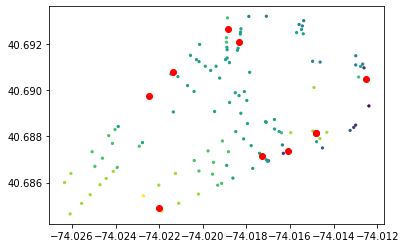

In [20]:
visualize_2d(dense_lu_solution)

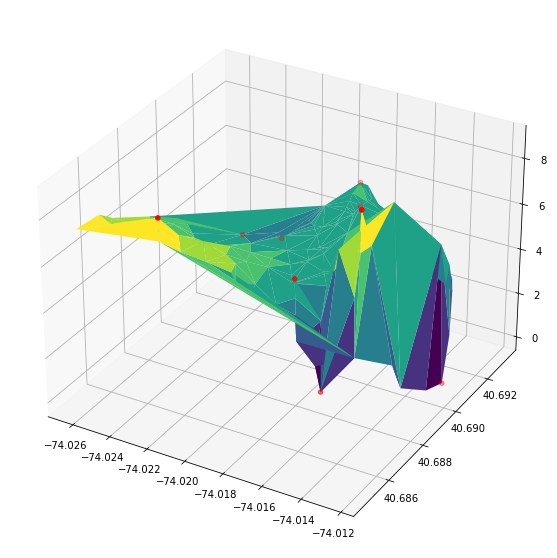

In [21]:
visualize_height(dense_lu_solution)

<BarContainer object of 9 artists>

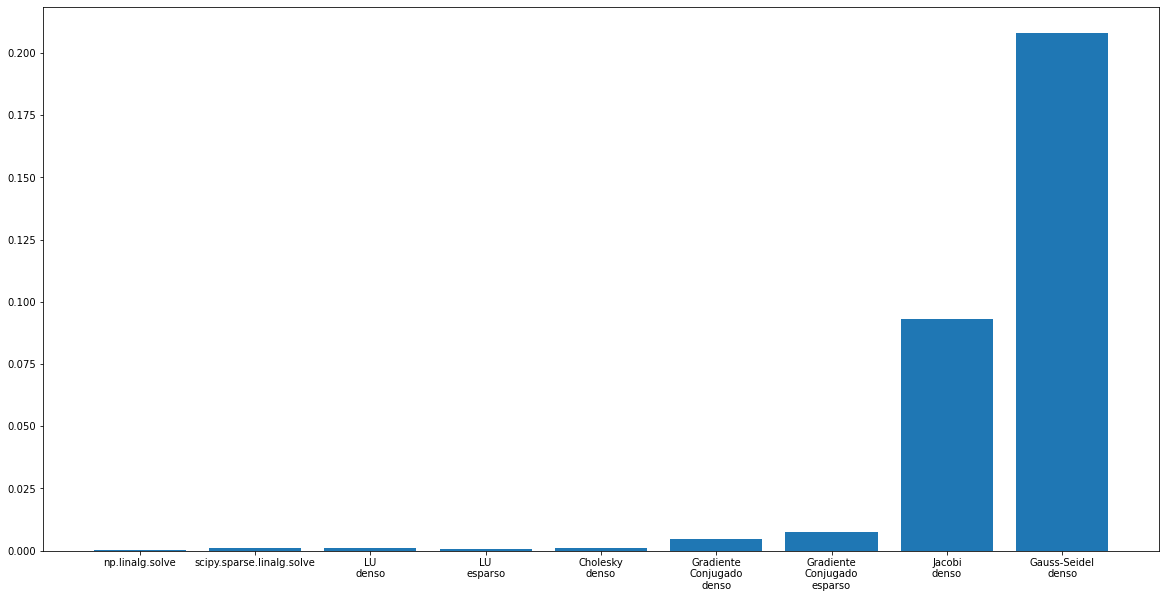

In [36]:
# Visualização de tempo
fig, ax = plt.subplots(figsize=[20,10])
ax.bar(range(len(times)), times, tick_label=[i.replace(" ", "\n") for i in times_labels])